## Last Update: 2020-6-23
2020-06-17 File Created <br>
2020-06-17 Run fsps <br>
2020-06-23 Find parameters range, creat saving method <br> 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# Cell magic method always stays at the top of the cell

# Imports from the Python standard library should be at the top
import os
import copy
import pickle
import itertools 
import corner
import math as math

# Do not import * unless you know what you are doing
import numpy as np 
import pandas as pd

import fsps
import sedpy
import lineid_plot

from sedpy.observate import getSED, vac2air, air2vac

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)

import astropy.units as u
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.constants import c, L_sun, pc
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import equivalent_width

from prospect import models
from prospect.models import priors

import torch
import torch.nn as nn

from scipy.stats import entropy

# re-defining plotting defaults
from matplotlib import rcParams

from dwarf_models_modified import SDSS_EMLINES, simulate_dwarf_sed, test_single_model,\
    sigma_clipping_continuum, measure_ew_emission_line, design_model_grid,\
    generate_dwarf_population, measure_color_ew, plot_models_with_sdss, setup_fsps_spop

rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 22})



ORG = plt.get_cmap('OrRd')
ORG_2 = plt.get_cmap('YlOrRd')
BLU = plt.get_cmap('PuBu')

### Read in the SDSS catalog

In [2]:
sdss_cat = Table.read('/Users/runquanguan/Documents/Dwarf_SDSS_8_9_SF_v2.0.fits')

em_flag = (np.isfinite(sdss_cat['M_u']) & np.isfinite(sdss_cat['M_r']) & \
           np.isfinite(sdss_cat['M_g']) & np.isfinite(sdss_cat['M_i']) &\
           np.isfinite(sdss_cat['OIII_5007_EQW']) & \
           np.isfinite(sdss_cat['H_ALPHA_EQW']) &\
           np.isfinite(sdss_cat['H_BETA_EQW']))

sdss_use = sdss_cat[em_flag]


SDSS_EMLINES = {\
    'OII_3726': {'cen':3726.032, 'low':3717.0, 'upp':3737.0},\
    'OII_3729': {'cen':3728.815, 'low':3717.0, 'upp':3737.0},\
    'NeIII_3869': {'cen':3869.060, 'low':3859.0, 'upp':3879.0}, \
    'H_delta': {'cen':4101.734, 'low':4092.0, 'upp':4111.0},\
    'H_gamma': {'cen':4340.464, 'low':4330.0, 'upp':4350.0},\
    'OIII_4363': {'cen':4363.210, 'low':4350.0, 'upp':4378.0},\
    'H_beta': {'cen':4861.325, 'low':4851.0, 'upp':4871.0},\
    'OIII_4959': {'cen':4958.911, 'low':4949.0, 'upp':4969.0},\
    'OIII_5007': {'cen':5006.843, 'low':4997.0, 'upp':5017.0},\
    'HeI_5876': {'cen':5875.67, 'low':5866.0, 'upp':5886.0},\
    'OI_6300': {'cen':6300.304, 'low':6290.0, 'upp':6310.0},\
    'NII_6548': {'cen':6548.040, 'low':6533.0, 'upp':6553.0},\
    'H_alpha': {'cen':6562.800, 'low':6553.0, 'upp':6573.0},\
    'NII_6584': {'cen':6583.460, 'low':6573.0, 'upp':6593.0},\
    'SII_6717': {'cen':6716.440, 'low':6704.0, 'upp':6724.0},\
    'SII_6731': {'cen':6730.810, 'low':6724.0, 'upp':6744.0},\
    'ArIII7135': {'cen':7135.8, 'low':7130.0, 'upp':7140.0}
}


### Procedure to generate model

In [3]:
# Gaussian distribution with boundary as prior for key parameters
set_size = 5000


tau_arr = [float(priors.ClippedNormal(mean=2.6, sigma=0.3, mini=1.0, maxi=8.0).sample()) for _ in range(set_size)]
const_arr =  [float(priors.ClippedNormal(mean=0.3, sigma=0.3, mini=0.0, maxi=0.49).sample()) for _ in range(set_size)]
tage_arr =  [float(priors.ClippedNormal(mean=6.5, sigma=0.1, mini=1.0, maxi=11.0).sample()) for _ in range(set_size)]
fburst_arr =  [float(priors.ClippedNormal(mean=0.6, sigma=0.1, mini=0.0, maxi=0.8).sample()) for _ in range(set_size)]
tburst_arr =  [float(priors.ClippedNormal(mean=5.0, sigma=0.5, mini=0.0, maxi=8.0).sample()) for _ in range(set_size)]
logzsol_arr =  [float(priors.ClippedNormal(mean=-0.8, sigma=0.5, mini=-1.5, maxi=0.0).sample()) for _ in range(set_size)]
gas_logz_arr =  [float(priors.ClippedNormal(mean=-0.5, sigma=0.6, mini=-1.5, maxi=0.0).sample()) for _ in range(set_size)]
gas_logu_arr =  [float(priors.ClippedNormal(mean=-3.2, sigma=0.5, mini=-4.0, maxi=-1.0).sample()) for _ in range(set_size)]

# Fix the fburst + const > 1 issue
for ii in np.arange(len(const_arr)):
    if const_arr[ii] + fburst_arr[ii] >= 0.95:
        f_over = (const_arr[ii] + fburst_arr[ii]) - 0.95
        if fburst_arr[ii] >= (f_over + 0.01):
            fburst_arr[ii] = fburst_arr[ii] - (f_over + 0.01)
        else:
            const_arr[ii] = const_arr[ii] - (f_over + 0.01)

# Fixed the rest
dust1_arr = np.full(set_size, 0.1)
dust2_arr = np.full(set_size, 0.0)
sf_trunc_arr = np.full(set_size, 0.0)

# List of model parameters
dwarf_sample_parameters = [
     {
         'dust1': dust1_arr[ii], 
         'dust2': dust2_arr[ii],
         'logzsol': logzsol_arr[ii], 
         'gas_logz': gas_logz_arr[ii], 
         'gas_logu': gas_logu_arr[ii],
         'const': const_arr[ii], 
         'tau': tau_arr[ii], 
         'tage': tage_arr[ii],
         'sf_trunc': sf_trunc_arr[ii], 
         'fburst': fburst_arr[ii], 
         'tburst': tburst_arr[ii]
     } for ii in np.arange(set_size)
]

# Double check
for ii, model in enumerate(dwarf_sample_parameters):
    if model['fburst'] + model['const'] >= 0.99:
        print(ii, model['fburst'], model['const'])

In [5]:
# Initialize the spop model
spop_tau = setup_fsps_spop(
    zcontinuous=1, imf_type=2, sfh=1, dust_type=0, 
    dust_index=-1.3, dust1_index=-1.0)

# Get the SDSS filters
sdss_bands = fsps.find_filter('SDSS')

print("# Done!")

# Done!


In [ ]:
# Generate model spectra and seds
dwarf_sample_gaussian = generate_dwarf_population(
    spop_tau, dwarf_sample_parameters, filters=sdss_bands, n_jobs=4)

print("# Model spectra are generated !")

# Measure colors and emission line EWs
# - SDSS_EMLINES is a pre-defined dict of emission lines center wavelength and the 
# wavelength window for measuring EW.
# - You can save the results in a numpy array
dwarf_sample_table = measure_color_ew(
    dwarf_sample_gaussian, em_list=SDSS_EMLINES, output=None)

print("Job finished!")

# Will use multi-processing with 4 cores!


2020-08-02 05:45:58,380	INFO resource_spec.py:212 -- Starting Ray with 4.1 GiB memory available for workers and up to 2.05 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-02 05:45:58,736	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-02 05:45:59,817	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


In [13]:
dwarf_sample_gaussian[0]

{'dust1': 0.1,
 'dust2': 0.0,
 'logzsol': -0.5369099419496755,
 'gas_logz': -1.050386161196065,
 'gas_logu': -2.6695170720742474,
 'const': 0.4472957387857919,
 'tau': 2.5171497867513217,
 'tage': 6.787938801496633,
 'sf_trunc': 0.0,
 'fburst': 0.49270426121420796,
 'tburst': 5.084575124211341,
 'wave': array([3700.853 , 3701.7531, 3702.6535, ..., 7398.1374, 7399.0375,
        7399.9377]),
 'spec_em': array([0.00012063, 0.0001193 , 0.00011483, ..., 0.00010325, 0.00010329,
        0.0001031 ]),
 'mstar': 0.6418898942409343,
 'emline_luminosity': array([1.35220354e-05, 1.40575968e-05, 1.63511295e-05, 1.89536165e-05,
        2.31697227e-05, 2.67833841e-05, 3.25306951e-05, 4.68083159e-02,
        1.88537972e-05, 3.98798286e-05, 9.83516198e-05, 3.48861476e-06,
        1.82052137e-05, 1.00163813e-05, 5.32102586e-04, 3.48653897e-04,
        4.20370315e-06, 1.75537612e-05, 6.35499480e-06, 1.37378491e-05,
        7.03392995e-05, 4.63016030e-05, 1.43494811e-05, 4.66185183e-05,
        7.95488269

/Users/runquanguan/Documents/Dwarf_FSPS/Dwarf_FSPS/dwarf_models.py:755: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Dwarf_FSPS/Dwarf_FSPS/dwarf_models.py:755: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Dwarf_FSPS/Dwarf_FSPS/dwarf_models.py:771: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Dwarf_FSPS/Dwarf_FSPS/dwarf_models.py:771: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Dwarf_FSPS/Dwarf_FSPS/dwarf_models.py:787: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_g'] - sdss_data['M_i'], np.

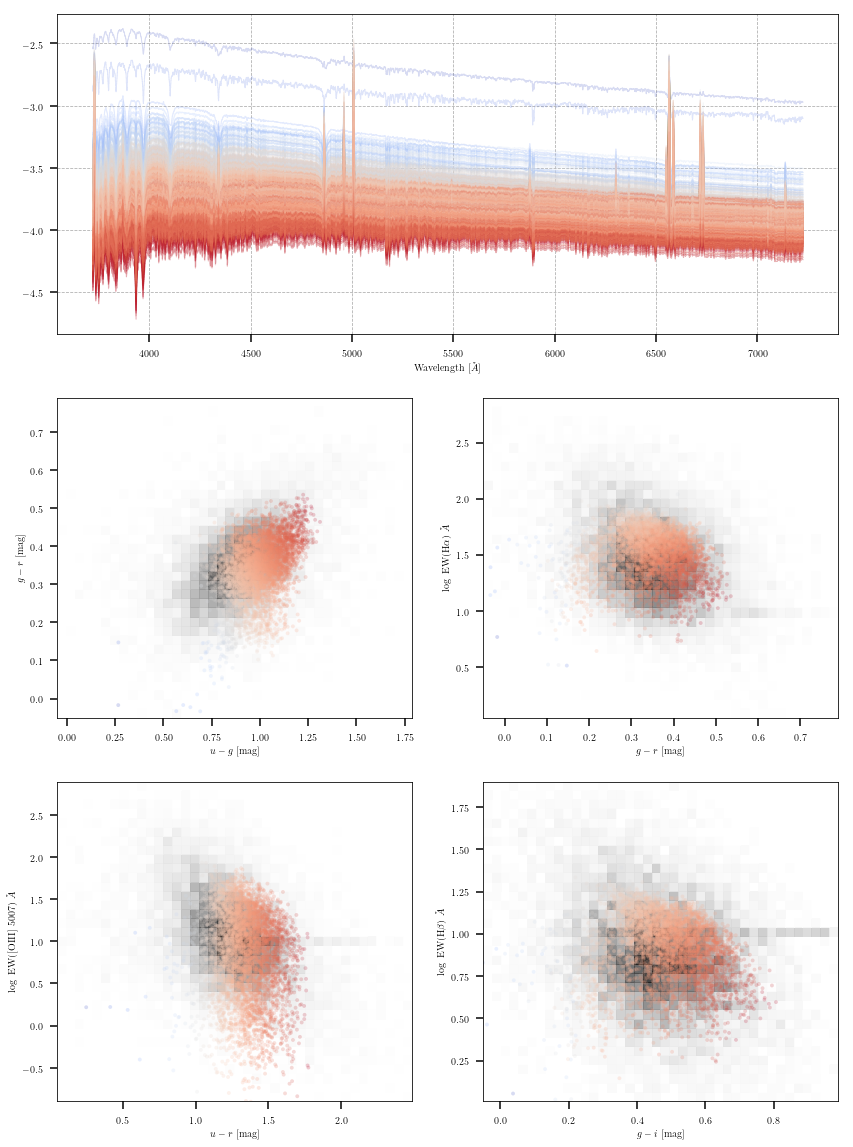

In [6]:
# Make a summary plot
_ = plot_models_with_sdss(
    dwarf_sample_table, sdss_use, wave_min=3720, wave_max=7225,
    size_symbol=15, alpha_spec=0.2, alpha_symbol=0.2, ecolor_symbol='none')

## K-L Entropy


In [7]:
bin_size = 100

ur_size = np.linspace(0,2.5,bin_size)
ug_size = np.linspace(0,1.75,bin_size)
gr_size = np.linspace(-0.1,0.8,bin_size)
gi_size = np.linspace(-0.2,1.2,bin_size)
ha_size = np.linspace(0,3,bin_size)
hb_size = np.linspace(-0.5,2.5,bin_size)
oiii_size = np.linspace(-1,3,bin_size)

obs_ur = data_to_distribution(np.asarray(sdss_use['M_u'] - sdss_use['M_r']), ur_size)
obs_ug = data_to_distribution(np.asarray(sdss_use['M_u'] - sdss_use['M_g']), ug_size)
obs_gr = data_to_distribution(np.asarray(sdss_use['M_g'] - sdss_use['M_r']), gr_size)
obs_gi = data_to_distribution(np.asarray(sdss_use['M_g'] - sdss_use['M_i']), gi_size)
obs_ha = data_to_distribution(np.log10(abs(sdss_use['H_ALPHA_EQW'])), ha_size)
obs_hb = data_to_distribution(np.log10(abs(sdss_use['H_BETA_EQW'])), hb_size)
obs_oiii = data_to_distribution(np.log10(abs(sdss_use['OIII_5007_EQW'])), oiii_size)

model_ur = data_to_distribution(dwarf_sample_table['ur_color'], ur_size)
model_ug = data_to_distribution(dwarf_sample_table['ug_color'], ug_size)
model_gr = data_to_distribution(dwarf_sample_table['gr_color'], gr_size)
model_gi = data_to_distribution(dwarf_sample_table['gi_color'], gi_size)
model_ha = data_to_distribution(np.log10(abs(dwarf_sample_table['ew_halpha'])), ha_size)
model_hb = data_to_distribution(np.log10(abs(dwarf_sample_table['ew_hbeta'])), hb_size)
model_oiii = data_to_distribution(np.log10(abs(dwarf_sample_table['ew_oiii_5007'])), oiii_size)

obs_stack = np.transpose(np.vstack([obs_ur, obs_ug, obs_gr, 
                                    obs_gi, obs_ha, obs_hb, 
                                    obs_oiii]))

model_stack = np.transpose(np.vstack([model_ur, model_ug, model_gr, 
                                    model_gi, model_ha, model_hb, 
                                    model_oiii]))




total_loss = entropy(obs = obs_stack, model = model_stack)

total_loss

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/runquanguan/.local/lib/python3.7/site-packages/t

0.0033293605031145548

## Corner Plot

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invali

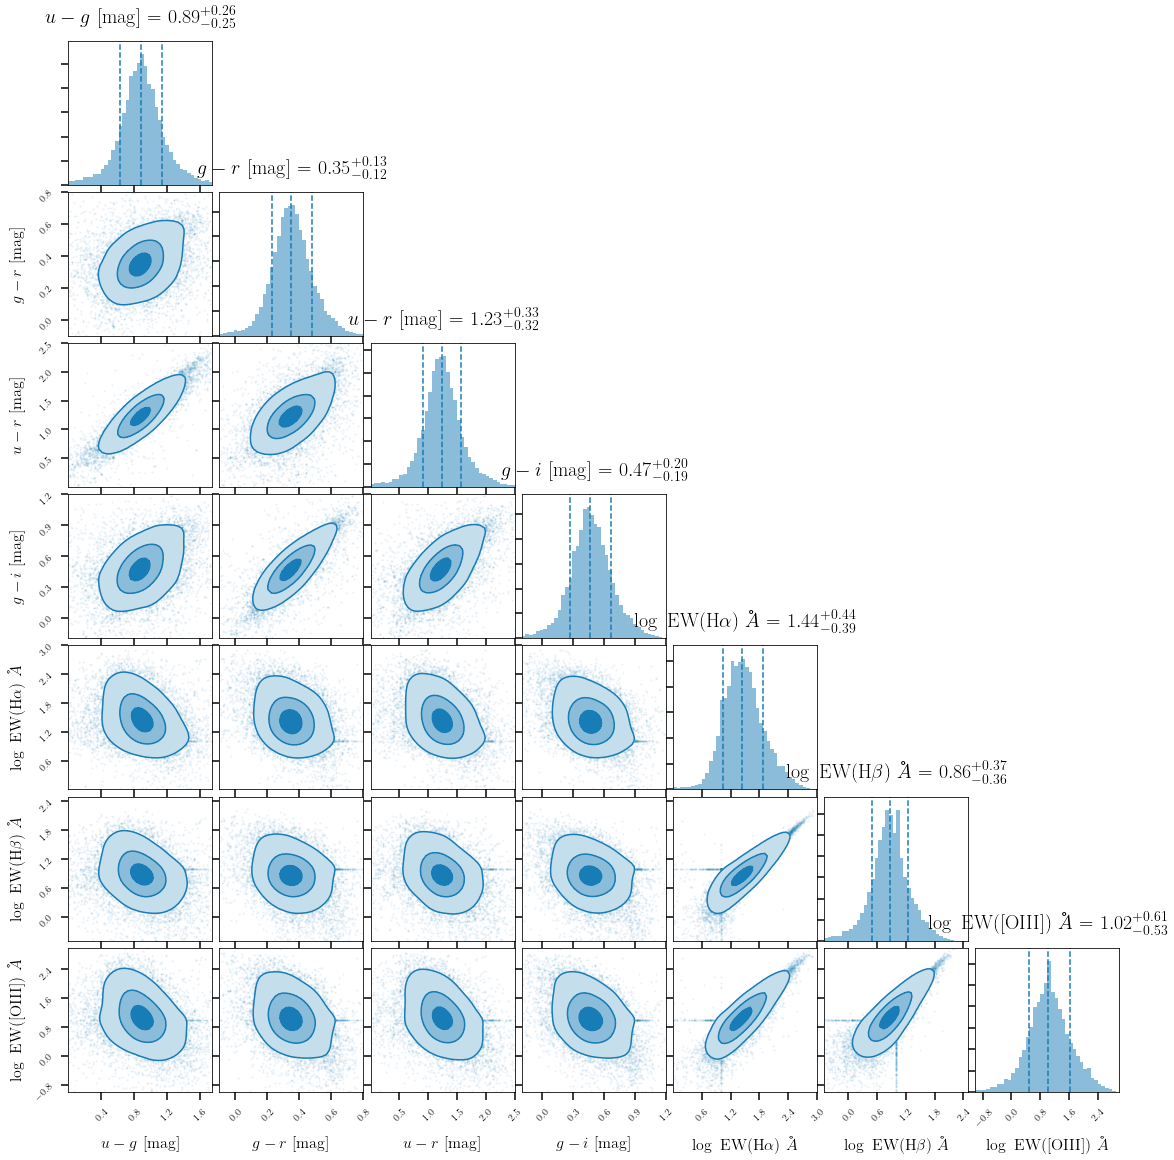

In [8]:
models = dwarf_sample_table
sdss_data = sdss_use


sdss_ug = np.array(sdss_data['M_u'] - sdss_data['M_g'])
sdss_gr = np.array(sdss_data['M_g'] - sdss_data['M_r'])
sdss_ur = np.array(sdss_data['M_u'] - sdss_data['M_r'])
sdss_gi = np.array(sdss_data['M_g'] - sdss_data['M_i'])
sdss_HA = np.array(np.log10(abs(sdss_data['H_ALPHA_EQW'])))
sdss_HB = np.array(np.log10(abs(sdss_data['H_BETA_EQW'])))
sdss_OIII =  np.array(np.log10(abs(sdss_data['OIII_5007_EQW'])))

data = np.transpose(np.vstack([sdss_ug, sdss_gr, sdss_ur, sdss_gi, sdss_HA, sdss_HB, sdss_OIII]))

figure = corner.corner(data, labels=[r'$u-g\ [\mathrm{mag}]$',
                                     r'$g-r\ [\mathrm{mag}]$',
                                     r'$u-r\ [\mathrm{mag}]$', 
                                     r'$g-i\ [\mathrm{mag}]$',
                                     r'$\log\ \mathrm{EW(H}\alpha)\ \AA$',
                                     r'$\log\ \mathrm{EW(H}\beta)\ \AA$',
                                     r'$\log\ \mathrm{EW([OIII])}\ \AA$'],
                       range = [(0,1.75),(-0.1,0.8),(0,2.5),(-0.2,1.2),(0,3),(-0.5,2.5),(-1,3)],
                       bins=40, color=BLU(0.7),
                       smooth=2, 
                       label_kwargs={'fontsize': 16},
                       quantiles=[0.16, 0.5, 0.84],
                       levels=[0.16, 0.50, 0.84],
                       plot_contours=True,
                       fill_contours=True,
                       show_titles=True,
                       title_kwargs={"fontsize": 20},
                       hist_kwargs={"histtype": 'stepfilled', "alpha": 0.5,
                                     "edgecolor": "none"},
                       use_math_text=True)

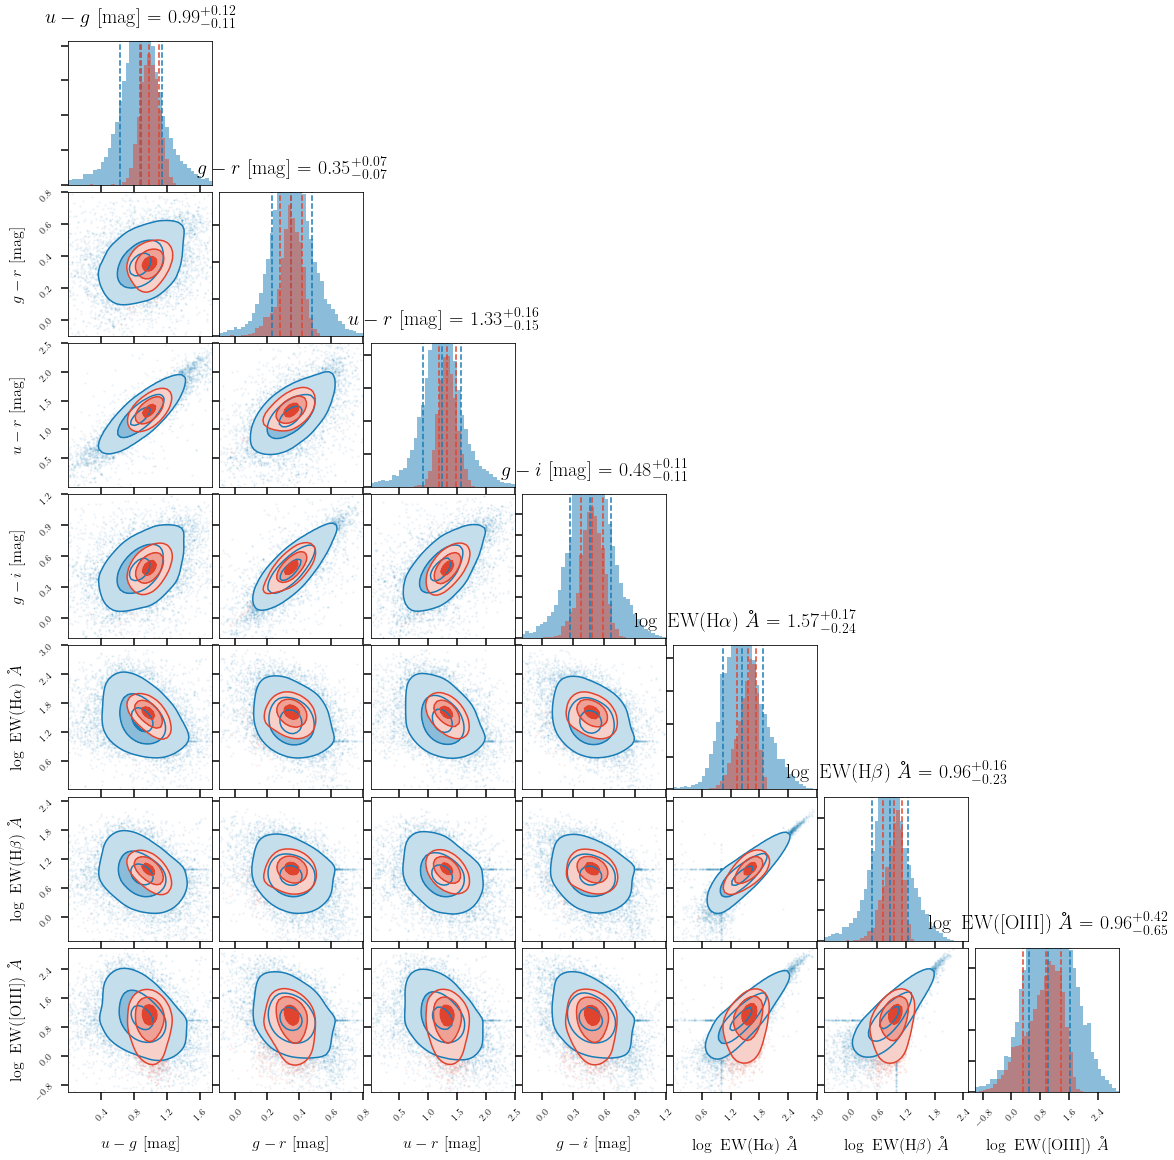

In [9]:


sps_ug = np.array(models['ug_color'])
sps_gr = np.array(models['gr_color'])
sps_ur = np.array(models['ur_color'])
sps_gi = np.array(models['gi_color'])
sps_HA = np.array(np.log10(abs(models['ew_halpha'])))
sps_HB = np.array(np.log10(abs(models['ew_hbeta'])))
sps_OIII = np.array(np.log10(abs(models['ew_oiii_5007'])))


sps_sample = np.transpose(np.vstack([sps_ug, sps_gr, sps_ur, sps_gi, 
                                       sps_HA, sps_HB, sps_OIII]))

figure_overlap = corner.corner(sps_sample, 
                               fig = figure,
                               labels=[r'$u-g\ [\mathrm{mag}]$',
                                     r'$g-r\ [\mathrm{mag}]$',
                                     r'$u-r\ [\mathrm{mag}]$', 
                                     r'$g-i\ [\mathrm{mag}]$',
                                     r'$\log\ \mathrm{EW(H}\alpha)\ \AA$',
                                     r'$\log\ \mathrm{EW(H}\beta)\ \AA$',
                                     r'$\log\ \mathrm{EW([OIII])}\ \AA$'],
                               range = [(0,1.75),(-0.1,0.8),(0,2.5),(-0.2,1.2),(0,3),(-0.5,2.5),(-1,3)],
                       bins=40, color=ORG(0.7),
                       smooth=2, 
                       label_kwargs={'fontsize': 16},
                       quantiles=[0.16, 0.5, 0.84],
                       levels=[0.16, 0.50, 0.84],
                       plot_contours=True,
                       fill_contours=True,
                       show_titles=True,
                       title_kwargs={"fontsize": 20},
                       hist_kwargs={"histtype": 'stepfilled', "alpha": 0.5,
                                     "edgecolor": "none"},
                       use_math_text=True)


figure_overlap